<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x   

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [22]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [23]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [24]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [25]:
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
(df.iloc[:, 1])

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64

## Разделение на train, test

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [28]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```
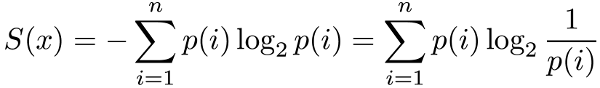

In [35]:
def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """
    return df['Survived'].value_counts().idxmax()

    #if df.sum()<df.shape[0]/2:
        #return(0)
    #else:
        #return(1)


def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    elements, counts = np.unique(target, return_counts = True)
    entropy = np.sum([(-counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts)) for i in range(len(elements))]) 
    return (entropy)

def splitDf(threshold,df):
    lDf = df.iloc[:threshold]
    rDf = df.iloc[threshold:]
    return lDf,rDf

def IG(feature, threshold, df):
    left_df, right_df = splitDf(threshold, df)
    old = get_entropy(pd.Series(df[feature]))
    left_ratio = left_df.shape[0] / df.shape[0]
    new = (get_entropy(pd.Series(left_df[feature]))) * left_ratio + (get_entropy(pd.Series(right_df[feature]))) * (1 - left_ratio)
    g = old - new
    return g   
"""
def IG(ficha,threshold,df):
    lDf, rDf = splitDf(threshold,df)
    prev = get_entropy(pd.Series(df[ficha]))
    leftRatio = lDf.shape[0] / df.shape[0]
    curr = (get_entropy(pd.Series(lDf[ficha])))*leftRatio + (get_entropy(pd.Series(rDf[ficha]))) * (1-leftRatio)
    ig = prev - curr
    return ig
"""
def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
 
        Output - прирост энтропии, порог разбиения
    """
    IGdict = {}
    for threshold in range(df[f_name].shape[0]):
        IGdict[threshold] = IG(f_name,threshold,df)
    threshold = max(IGdict, key = IGdict.get)
    bestIG = IGdict[threshold]
    return (bestIG,threshold)
    """
        S_0 = get_entropy(df.iloc[:, 1])
        N = df.shape[0]
        delta_entropy = 0
        for ind in range(df.shape[0]):
            left, right = df.iloc[:ind, :], df.iloc[ind:, :]
            entropy_left = get_entropy(left[f_name]) 
            entropy_right = get_entropy(right[f_name])
            N_0 = np.sum(left[f_name] == 0)/N
            N_1 = 1 - N_0
            IG = S_0 - (N_0)*entropy_left - (N_1)*entropy_right
            if IG > delta_entropy:
                delta_entropy = IG
                threshold = ind#df.iloc[ind, :][f_name]

        return (delta_entropy, threshold)
    """

def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    IGdict = {}
    for i in [col for col in list(df.columns) if col != "Survived"]:
        IGdict[i] = feature_separation(df,i)
    sep_feature = max(IGdict,key = IGdict.get)
    threshold = IGdict[sep_feature][1]
    groups = splitDf(threshold,df)
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}



def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = node['right'] = get_target(pd.concat([df_left, df_right], ignore_index = True))# YOUR CODE HERE
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        node['left'], node['right'] = get_target(df_left),get_target(df_right) # YOUR CODE HERE
        return
    
    else:
        node['left'] = best_separation(df_left)# YOUR CODE HERE
        split(node['left'], max_depth, depth + 1)

        node['right'] = best_separation(df_right)# YOUR CODE HERE
        split(node['right'], max_depth, depth + 1)
        
        
def fit_my_tree(df, df_y, max_depth):
    """
    Функция для обучения дерева
    Input - df: DataFrame
    max_depth: максимальная глубина дерева
    """
    root = best_separation(pd.concat([df, df_y], axis=1))
    split(root, max_depth, 1)
    return root


In [39]:
my_tree = fit_my_tree(X_train,y_train, 6)
print(my_tree)

{'feature_name': 'Fare', 'threshold': 488, 'left': {'feature_name': 'Fare', 'threshold': 192, 'left': {'feature_name': 'Fare', 'threshold': 77, 'left': {'feature_name': 'Fare', 'threshold': 39, 'left': {'feature_name': 'Fare', 'threshold': 20, 'left': {'feature_name': 'Fare', 'threshold': 10, 'left': 1, 'right': 0}, 'right': {'feature_name': 'Fare', 'threshold': 11, 'left': 0, 'right': 0}}, 'right': {'feature_name': 'Fare', 'threshold': 23, 'left': {'feature_name': 'Age', 'threshold': 13, 'left': 1, 'right': 0}, 'right': {'feature_name': 'Fare', 'threshold': 7, 'left': 0, 'right': 0}}}, 'right': {'feature_name': 'Fare', 'threshold': 45, 'left': {'feature_name': 'Fare', 'threshold': 22, 'left': {'feature_name': 'Fare', 'threshold': 11, 'left': 1, 'right': 0}, 'right': {'feature_name': 'Age', 'threshold': 11, 'left': 0, 'right': 0}}, 'right': {'feature_name': 'Fare', 'threshold': 43, 'left': {'feature_name': 'Age', 'threshold': 23, 'left': 0, 'right': 1}, 'right': {'feature_name': 'Fare'

## Predict MyDecisionTree  

In [40]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [41]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)

<ipython-input-40-502e52ba210a>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

## Сравнение метрик

In [44]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [45]:
abs(my_roc_test - 0.6)

0.338928376161837

In [46]:
assert abs(my_roc_test - 0.6) >= 0.2